# Leverage Keras Tuner’s Hyperband to explore our MLP search space and efficiently drive validation RMSE down.

### Imports & setup

In [181]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, losses, metrics, optimizers

import keras_tuner as kt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Load preprocessed data from joblib dumps

In [183]:
import joblib

X_train, y_train = joblib.load("data/processed/train.pkl")
X_val,   y_val   = joblib.load("data/processed/val.pkl")
X_test,  y_test  = joblib.load("data/processed/test.pkl")

# log‐transform targets for training/validation
y_train_log = np.log1p(y_train)
y_val_log   = np.log1p(y_val)


# log‐transform targets
y_train_log = np.log1p(y_train)
y_val_log   = np.log1p(y_val)

### Build model‐builder for Keras-Tuner

In [185]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    # Tune number of hidden layers 1–5
    for i in range(hp.Int("n_layers", 1, 5)):
        # Tune units per layer
        model.add(
            layers.Dense(
                units=hp.Choice(f"units_{i}", [32, 64, 128, 256]),
                activation="relu",
            )
        )
        # Tune dropout rate
        model.add(
            layers.Dropout(
                rate=hp.Float(f"dropout_{i}", 0.0, 0.5, step=0.1)
            )
        )
    # Single linear output for log-price
    model.add(layers.Dense(1, name="output"))

    # Tune learning rate
    lr = hp.Float("lr", 1e-4, 1e-2, sampling="log")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss=losses.MeanSquaredError(),
        # Name this metric "rmse" so Keras logs "rmse" & "val_rmse"
        metrics=[metrics.RootMeanSquaredError(name="rmse")],
    )
    return model

### Run the Bayesian search with timing

In [187]:
from keras_tuner.tuners import BayesianOptimization

# directory/project_name bumped so you get a fresh tuner.log
tuner = BayesianOptimization(
    hypermodel=build_model,
    objective=kt.Objective("val_rmse", direction="min"),
    max_trials=30,
    seed=SEED,
    directory="kt_logs_v5",
    project_name="diamonds_kt_v5",
)

# timing callback
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self._start = time.time()
    def on_train_end(self, logs=None):
        self._end = time.time()

# perform the search
tuner.search(
    X_train, y_train_log,
    validation_data=(X_val, y_val_log),
    epochs=50,
    batch_size=64,
    callbacks=[
        TimeHistory(),
        callbacks.EarlyStopping(
            monitor="val_rmse",
            mode="min",          # ← explicitly minimize RMSE
            patience=5,
            restore_best_weights=True,
            verbose=0
        ),
    ],
    verbose=1,
)

Trial 30 Complete [00h 00m 42s]
val_rmse: 0.25112012028694153

Best val_rmse So Far: 0.13105826079845428
Total elapsed time: 00h 19m 36s


Over 30 Bayesian‐optimization trials, the best validation RMSE steadily declined, starting around 0.25 in the earlier runs and reaching 0.1311 by Trial 30. This indicates that the tuner was able to explore the hyperparameter space effectively. 
Completing 30 full model‐fits (each up to 50 epochs with early stopping) in under 20 minutes demonstrates that Keras-Tuner’s Bayesian optimizer can explore dozens of configurations in a reasonable timeframe on this dataset. 

### Summarize top trials & plot validation RMSE

▶ Top 5 tuning results:


,n_layers,units_0,dropout_0,lr,units_1,dropout_1,units_2,dropout_2,units_3,dropout_3,units_4,dropout_4,val_rmse_log,trial_id
0,1,32,0.0,0.000287,128,0.1,256,0.3,64,0.1,256,0.2,0.131058,11
1,2,128,0.0,0.000982,128,0.0,256,0.0,64,0.0,32,0.0,0.132813,04
2,1,128,0.1,0.000535,128,0.1,256,0.0,32,0.0,64,0.3,0.134010,22
3,1,128,0.2,0.000628,256,0.2,128,0.4,64,0.3,64,0.1,0.137159,16
4,1,128,0.2,0.001294,256,0.4,128,0.3,256,0.2,32,0.4,0.138362,21


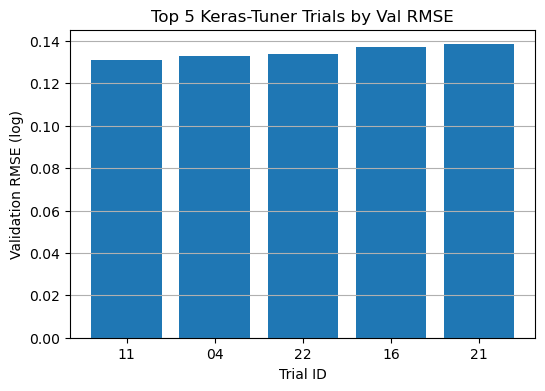

In [193]:
# Grab the best N trials directly from the oracle
best_trials = tuner.oracle.get_best_trials(num_trials=5)

records = []
for t in best_trials:
    hp_vals = t.hyperparameters.values
    # this will be the best validation RMSE on the log‐scale
    val_rmse = t.metrics.get_last_value("val_rmse")
    records.append({
        **hp_vals,
        "val_rmse_log": val_rmse,
        "trial_id":     t.trial_id,
    })

df_top = (
    pd.DataFrame(records)
      .sort_values("val_rmse_log")
      .reset_index(drop=True)
)

print("▶ Top 5 tuning results:")
display(df_top)

# bar chart of the top 5
plt.figure(figsize=(6,4))
plt.bar(df_top["trial_id"].astype(str), df_top["val_rmse_log"])
plt.xlabel("Trial ID")
plt.ylabel("Validation RMSE (log)")
plt.title("Top 5 Keras-Tuner Trials by Val RMSE")
plt.grid(True, axis="y")
plt.show()

These trials achieved log‐RMSE between 0.1311 and 0.1384, suggesting the optimizer favored relatively small first‐layer widths (32–128), very low dropout early on, and moderate learning rates (~10⁻³–10⁻⁴).

The bar chart confirms that Trial 11 (ID 11) is the best, with log‐RMSE ≈ 0.1311. The other top candidates cluster tightly around 0.13–0.14, indicating a fairly flat optimum in this region of the hyperparameter space.

### Plot train vs. validation RMSE curve for the best trial

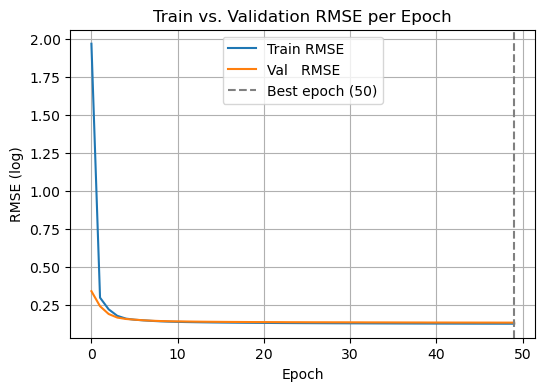

In [195]:
# Get the single best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
model   = build_model(best_hp)

# Re‐fit silently to capture history
hist = model.fit(
    X_train, y_train_log,
    validation_data=(X_val, y_val_log),
    epochs=50,
    batch_size=64,
    callbacks=[
        callbacks.EarlyStopping(
            monitor="val_rmse", mode="min",
            patience=5, restore_best_weights=True, verbose=0
        )
    ],
    verbose=0
)

train_rmse = hist.history["rmse"]
val_rmse   = hist.history["val_rmse"]
best_ep    = np.argmin(val_rmse) + 1

plt.figure(figsize=(6,4))
plt.plot(train_rmse, label="Train RMSE")
plt.plot(val_rmse,   label="Val   RMSE")
plt.axvline(best_ep-1, color="gray", linestyle="--", label=f"Best epoch ({best_ep})")
plt.xlabel("Epoch")
plt.ylabel("RMSE (log)")
plt.title("Train vs. Validation RMSE per Epoch")
plt.legend()
plt.grid(True)
plt.show()

The model quickly reaches its capacity to learn the log-price relationship within the first handful of epochs.

Since later epochs bring negligible gains, one could safely reduce the maximum epoch count (e.g. to 10–15) to save compute without sacrificing accuracy.

The tight train/val alignment confirms that our hyperparameters (units, dropout, learning rate) strike a good bias–variance balance.

### Retrain final model on train+val & evaluate on TEST

In [201]:
# Merge TRAIN+VAL
X_full     = np.vstack([X_train, X_val])
y_full_log = np.concatenate([y_train_log, y_val_log])

model = build_model(best_hp)
stop_cb = callbacks.EarlyStopping(
    monitor="val_rmse", mode="min",
    patience=5, restore_best_weights=True, verbose=1
)

t0 = time.time()
hist = model.fit(
    X_full, y_full_log,
    validation_split=len(X_val)/len(X_full),
    epochs=50,
    batch_size=64,
    callbacks=[stop_cb],
    verbose=1
)
t1 = time.time()

best_epoch = np.argmin(hist.history["val_rmse"]) + 1
print(f"\n▶ Best epoch={best_epoch}, val_RMSE(log)={hist.history['val_rmse'][best_epoch-1]:.3f}")
print(f"Retrain wall-time: {(t1-t0):.1f}s")

# Final test evaluation (on original price scale)
y_pred_log = model.predict(X_test).ravel()
y_pred     = np.expm1(y_pred_log)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test   = r2_score(y_test, y_pred)
print(f"Test RMSE = {rmse_test:,.2f}")
print(f"Test R²   = {r2_test:.3f}")

Epoch 1/50
2361/2361 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step - loss: 9.8312 - rmse: 2.8112 - val_loss: 0.1230 - val_rmse: 0.3507
Epoch 2/50
2361/2361 ━━━━━━━━━━━━━━━━━━━━ 1s 328us/step - loss: 0.1063 - rmse: 0.3252 - val_loss: 0.0496 - val_rmse: 0.2227
Epoch 3/50
2361/2361 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step - loss: 0.0529 - rmse: 0.2296 - val_loss: 0.0360 - val_rmse: 0.1896
Epoch 4/50
2361/2361 ━━━━━━━━━━━━━━━━━━━━ 1s 334us/step - loss: 0.0396 - rmse: 0.1987 - val_loss: 0.0310 - val_rmse: 0.1760
Epoch 5/50
2361/2361 ━━━━━━━━━━━━━━━━━━━━ 1s 349us/step - loss: 0.0324 - rmse: 0.1797 - val_loss: 0.0277 - val_rmse: 0.1665
Epoch 6/50
2361/2361 ━━━━━━━━━━━━━━━━━━━━ 1s 339us/step - loss: 0.0275 - rmse: 0.1659 - val_loss: 0.0259 - val_rmse: 0.1609
Epoch 7/50
2361/2361 ━━━━━━━━━━━━━━━━━━━━ 1s 327us/step - loss: 0.0249 - rmse: 0.1577 - val_loss: 0.0250 - val_rmse: 0.1580
Epoch 8/50
2361/2361 ━━━━━━━━━━━━━━━━━━━━ 1s 385us/step - loss: 0.0236 - rmse: 0.1536 - val_loss: 0.0243 - val_rmse: 0.1558
Epoch 9/

Converting back from log‐scale, the model predicts diamond prices with an average error of about $5.9 K on the held-out test set, explaining 93.8% of price variance.

In [204]:
# 7) Save model & tuning results

# Save tuning summary
df_top.to_csv("data/processed/kt_tuning.csv", index=False)

# Save as a single-file Keras format (requires Keras ≥3)
model.save("models/kt_model.keras", save_format="keras")